In [1]:
import os
import datetime

import IPython
import IPython.display
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.layers import LSTM , Bidirectional, Dropout
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

mpl.rcParams['axes.unicode_minus'] = False
font_name = fm.FontProperties(fname="c:\\windows\\fonts\\malgun.ttf").get_name()
rc('font', family=font_name)

mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings(action='ignore')

import lightgbm as lgb
from tqdm import tqdm 
import time

In [2]:
data = pd.read_csv('C:/Users/jhl/Downloads/gas_data.csv',encoding='cp949')

In [3]:
pd.isnull(data).sum()

연월일    0
시간     0
구분     0
공급량    0
dtype: int64

In [4]:
# preprocessing
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

data['연월일'] = pd.to_datetime(data['연월일'])

data['year'] = data['연월일'].dt.year
data['month'] = data['연월일'].dt.month
data['day'] = data['연월일'].dt.day
data['weekday'] = data['연월일'].dt.weekday

In [5]:
data['연월일'] = data['연월일'].astype('str')
data['시간'] = data['시간'].astype('str')
data['월일시'] = data['연월일'].str[5:] + '_' + data['시간']

## Preprocessing data

In [6]:
sup_df = pd.DataFrame()

In [7]:
# outlier 
for cat in tqdm(data['구분'].unique()) :
    df = data[data['구분'] == cat].reset_index(drop=True)
    
    for idx in np.arange(1,df.shape[0]-1) :
        
            f_b_avg = np.mean(df.loc[idx:idx+24,'공급량']) 

            
            if 1.5*f_b_avg < df['공급량'][idx] :
                
                df['공급량'][idx] = f_b_avg
            
    sup_df = pd.concat([sup_df, df])

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:28<00:00,  4.06s/it]


In [8]:
sup_df2 = pd.DataFrame()

In [9]:
for cat in tqdm(sup_df['구분'].unique()) :
    df = sup_df[sup_df['구분'] == cat].reset_index(drop=True)
    
    for idx in np.arange(1,df.shape[0]-1) :
        
            f_b_avg = np.mean(df.loc[idx:idx+24,'공급량']) 

            
            if 1.5*f_b_avg < df['공급량'][idx] :
                
                df['공급량'][idx] = f_b_avg
            
    sup_df2 = pd.concat([sup_df2, df])

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:27<00:00,  3.96s/it]


In [10]:
sup_df3 = sup_df2.reset_index(drop=True)

In [34]:
sup_df3.loc[sup_df3['공급량'] < 20,'공급량'] = np.nan

In [60]:
sup_df3.columns

Index(['연월일', '시간', '구분', '공급량', 'year', 'month', 'day', 'weekday', '월일시'], dtype='object')

In [62]:
fea = ['시간', '공급량', 'year', 'month', 'day', 'weekday']
fea_in = ['연월일', '구분','월일시']

In [56]:
sup_df3[fea]

,시간,공급량,year,month,day,weekday
0,1,2497.129,2013,1,1,1
1,2,2363.265,2013,1,1,1
2,3,2258.505,2013,1,1,1
3,4,2243.969,2013,1,1,1
4,5,2344.105,2013,1,1,1
...,...,...,...,...,...,...
368083,20,681.033,2018,12,31,0
368084,21,669.961,2018,12,31,0
368085,22,657.941,2018,12,31,0
368086,23,610.953,2018,12,31,0


In [58]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(sup_df3[fea])
df_imputed = pd.DataFrame(imputed, columns=sup_df3[fea].columns)
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   시간       368088 non-null  float64
 1   공급량      368088 non-null  float64
 2   year     368088 non-null  float64
 3   month    368088 non-null  float64
 4   day      368088 non-null  float64
 5   weekday  368088 non-null  float64
dtypes: float64(6)
memory usage: 16.8 MB


In [42]:
sup_df3.loc[sup_df3['공급량'] < 20,'공급량']

Series([], Name: 공급량, dtype: float64)

In [11]:
len(sup_df) == len(data)

True

In [67]:
sup_df_ = pd.concat([sup_df3[fea_in],df_imputed],axis=1)

In [68]:
idx_list = []
sup_rolling_df = pd.DataFrame()
# for i in tqdm(test['월일시']) :
#     df_mv_avg = data[data['월일시']==i]

for idx in tqdm(sup_df_['구분'].unique()) :
    temp_df = sup_df_[sup_df_['구분']==idx]
    temp_df['5D_moving_avg'] = temp_df['공급량'].rolling(window=5).mean()
    temp_df['5D_moving_avg'] = temp_df['5D_moving_avg'].fillna(method='backfill')
    sup_rolling_df = sup_rolling_df.append(temp_df)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 26.29it/s]


In [69]:
temp_df = pd.read_csv('C:/Users/jhl/Downloads/test/대전_한국가스공사_시간별 공급량.csv',encoding='cp949')

In [70]:
stl_df = pd.DataFrame()
stl_df['연월일'] = sup_rolling_df['연월일']
stl_df['공급량'] = sup_rolling_df['공급량']

In [71]:
stl_df['연월일'] = pd.to_datetime(stl_df['연월일'])

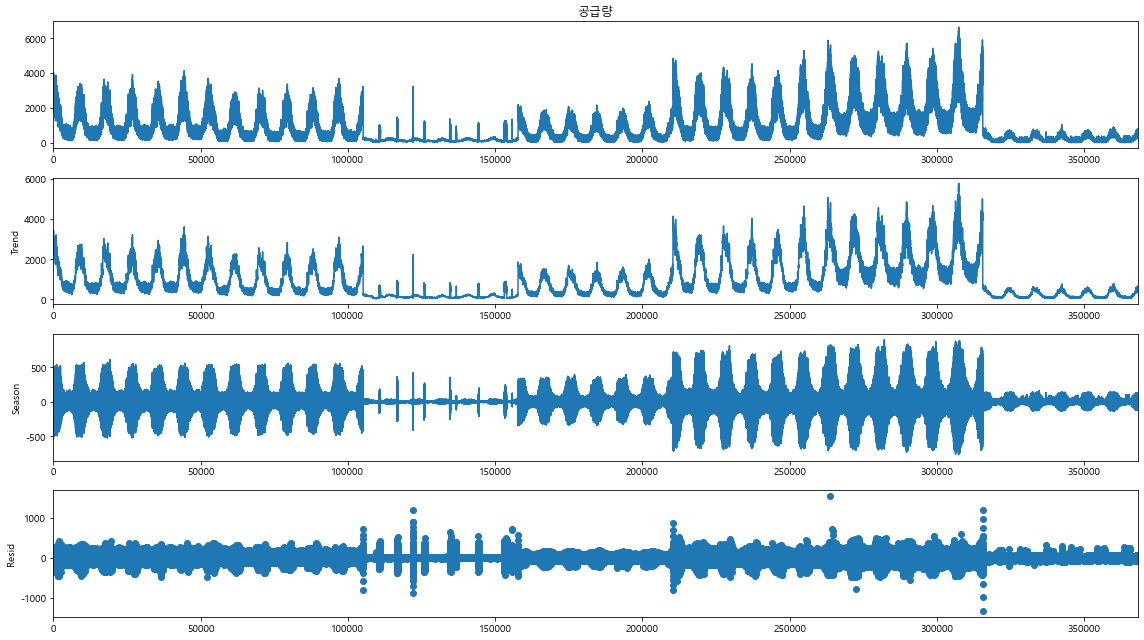

In [72]:
from statsmodels.tsa.seasonal import STL 
res = STL(stl_df['공급량'],seasonal=13,period=12).fit()
ax=res.plot() 
plt.show()

In [73]:
# stl_df['resid'] = res.resid
# stl_df['seasonal'] = res.seasonal
# stl_df['trend'] = res.trend

In [74]:
# concat_feature = ['시간', '구분', 'year', 'month', 'day', 'weekday', '월일시', '5D_moving_avg']
#final_df = pd.concat([sup_rolling_df[concat_feature], stl_df],axis=1)

In [75]:
# final_df['기온'] = temp_df['기온']
sup_rolling_df['기온'] = temp_df['기온']
final_df = sup_rolling_df.copy()

In [76]:
final_df['연월일'] = sup_rolling_df['연월일']

In [77]:
df = pd.get_dummies(final_df, columns = ['구분'])

In [78]:
df

,연월일,월일시,시간,공급량,year,month,day,weekday,5D_moving_avg,기온,구분_A,구분_B,구분_C,구분_D,구분_E,구분_G,구분_H
0,2013-01-01,01-01_1,1.0,2497.129,2013.0,1.0,1.0,1.0,2341.3946,-8.8,1,0,0,0,0,0,0
1,2013-01-01,01-01_2,2.0,2363.265,2013.0,1.0,1.0,1.0,2341.3946,-8.5,1,0,0,0,0,0,0
2,2013-01-01,01-01_3,3.0,2258.505,2013.0,1.0,1.0,1.0,2341.3946,-8.5,1,0,0,0,0,0,0
3,2013-01-01,01-01_4,4.0,2243.969,2013.0,1.0,1.0,1.0,2341.3946,-9.0,1,0,0,0,0,0,0
4,2013-01-01,01-01_5,5.0,2344.105,2013.0,1.0,1.0,1.0,2341.3946,-9.1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,2018-12-31,12-31_20,20.0,681.033,2018.0,12.0,31.0,0.0,604.7030,-2.8,0,0,0,0,0,0,1
368084,2018-12-31,12-31_21,21.0,669.961,2018.0,12.0,31.0,0.0,635.0934,-3.5,0,0,0,0,0,0,1
368085,2018-12-31,12-31_22,22.0,657.941,2018.0,12.0,31.0,0.0,658.2096,-4.0,0,0,0,0,0,0,1
368086,2018-12-31,12-31_23,23.0,610.953,2018.0,12.0,31.0,0.0,659.7726,-4.6,0,0,0,0,0,0,1


In [79]:
# features = ['시간', 'month', 'year','day', 'weekday', '5D_moving_avg', '기온', '구분_A', '구분_B', '구분_C', '구분_D',
#        '구분_E', '구분_G', '구분_H', '공급량']

features = ['연월일', '시간', '공급량', 'year', 'month', 'day', 'weekday', '월일시',
       '5D_moving_avg', '기온', '구분_A', '구분_B', '구분_C', '구분_D', '구분_E', '구분_G',
       '구분_H']

X = df[features]

In [80]:
# num = ['5D_moving_avg','기온','resid', 'seasonal', 'trend']
cat = ['시간', 'year', 'month', 'day', 'weekday', '구분_A', '구분_B','구분_C', '구분_D', '구분_E', 
            '구분_G', '구분_H']
X[cat] = X[cat].astype(str)

In [25]:
# train_years = ['2013','2014','2015','2016','2017']
# val_years = ['2018']
# train = X[X['year'].isin(train_years)]
# val = X[X['year'].isin(val_years)]

In [81]:
use_features =  ['시간', 'year', 'month', 'day', 'weekday', 
                 '5D_moving_avg', '기온','공급량',
                '구분_A', '구분_B', '구분_C','구분_D', '구분_E', '구분_G', '구분_H']
target = ['공급량']

In [82]:
df = df[use_features]

In [83]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]
train = df[df['year'].isin(train_years)]
val = df[df['year'].isin(val_years)]

In [84]:
X_train = train.drop(['공급량'],axis=1)
y_train = train['공급량']

X_val = val.drop(['공급량'],axis=1)
y_val = val['공급량']

In [85]:
X_val = X_val.astype(float)

In [86]:
X_train = X_train.astype(float)

In [87]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Standardization 평균 0 / 분산 1
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()

train_scaled = scaler.fit(X_train)

X_train_ = scaler.fit_transform(X_train)
X_val_ = train_scaled.fit_transform(X_val)

In [88]:
# input reshape 3 dim
X_train_t = X_train_.reshape(X_train_.shape[0], X_train_.shape[1], 1)
X_val_t = X_val_.reshape(X_val_.shape[0], X_val_.shape[1], 1)

X_train_t = X_train_.reshape(X_train_.shape[0], 1, X_train_.shape[1])
X_val_t = X_val_.reshape(X_val_.shape[0], 1, X_val_.shape[1])
print("최종 DATA")
print(X_train_t.shape, X_val_t.shape)
print(y_train)

최종 DATA
(306768, 1, 14) (61320, 1, 14)
0         2497.129
1         2363.265
2         2258.505
3         2243.969
4         2344.105
            ...   
359323     517.264
359324     530.896
359325     506.287
359326     470.638
359327     444.618
Name: 공급량, Length: 306768, dtype: float64


In [89]:
# split a univariate sequence into samples
def split_sequence_y(sequence, n_steps):
    y = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_y = sequence[end_ix]
        y.append(seq_y)
    return np.array(y)

In [90]:
# split a univariate sequence into samples
def split_sequence_X(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)

    return np.array(X)

In [91]:
n_steps = 24

In [92]:
# all data
X_train_t = split_sequence_X(X_train, n_steps)
X_val_t = split_sequence_X(X_val, n_steps)

y_train_t = split_sequence_y(y_train.values, n_steps)
y_val_t = split_sequence_y(y_val.values, n_steps)

In [93]:
len(X_train_t), len(X_val_t)

(306744, 61296)

In [94]:
X_train_t[0].shape

(24, 14)

In [95]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Standardization 평균 0 / 분산 1
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()

train_scaled = scaler.fit(X_train_t.reshape(-1,1))

X_train_ = scaler.fit_transform(X_train_t.reshape(-1,1))
X_val_ = train_scaled.fit_transform(X_val_t.reshape(-1,1))

X_train_ts = X_train_.reshape(306744,24,14)
X_val_ts = X_val_.reshape(61296,24,14)

In [96]:
X_train_ts.shape, X_val_ts.shape

((306744, 24, 14), (61296, 24, 14))

In [97]:
supliers_A_X = split_sequence_X(X_train[X_train['구분_A'] == 1].values, n_steps)
idx = X_train[X_train['구분_A'] == 1].index
supliers_A_y = split_sequence_y(y_train.loc[idx].values, n_steps)

supliers_B_X = split_sequence_X(X_train[X_train['구분_B'] == 1].values, n_steps)
idx = X_train[X_train['구분_B'] == 1].index
supliers_B_y = split_sequence_y(y_train.loc[idx].values, n_steps)

supliers_C_X = split_sequence_X(X_train[X_train['구분_C'] == 1].values, n_steps)
idx = X_train[X_train['구분_C'] == 1].index
supliers_C_y = split_sequence_y(y_train.loc[idx].values, n_steps)

supliers_D_X = split_sequence_X(X_train[X_train['구분_D'] == 1].values, n_steps)
idx = X_train[X_train['구분_D'] == 1].index
supliers_D_y = split_sequence_y(y_train.loc[idx].values, n_steps)

supliers_E_X = split_sequence_X(X_train[X_train['구분_E'] == 1].values, n_steps)
idx = X_train[X_train['구분_E'] == 1].index
supliers_E_y = split_sequence_y(y_train.loc[idx].values, n_steps)

supliers_G_X = split_sequence_X(X_train[X_train['구분_G'] == 1].values, n_steps)
idx = X_train[X_train['구분_G'] == 1].index
supliers_G_y = split_sequence_y(y_train.loc[idx].values, n_steps)

supliers_H_X = split_sequence_X(X_train[X_train['구분_H'] == 1].values, n_steps)
idx = X_train[X_train['구분_H'] == 1].index
supliers_H_y = split_sequence_y(y_train.loc[idx].values, n_steps)

In [98]:
supliers_A_X_val = split_sequence_X(X_val[X_val['구분_A'] == 1].values, n_steps)
idx = X_val[X_val['구분_A'] == 1].index
supliers_A_y_val = split_sequence_y(y_val.loc[idx].values, n_steps)

supliers_B_X_val = split_sequence_X(X_val[X_val['구분_B'] == 1].values, n_steps)
idx = X_val[X_val['구분_B'] == 1].index
supliers_B_y_val = split_sequence_y(y_val.loc[idx].values, n_steps)

supliers_C_X_val = split_sequence_X(X_val[X_val['구분_C'] == 1].values, n_steps)
idx = X_val[X_val['구분_C'] == 1].index
supliers_C_y_val = split_sequence_y(y_val.loc[idx].values, n_steps)

supliers_D_X_val = split_sequence_X(X_val[X_val['구분_D'] == 1].values, n_steps)
idx = X_val[X_val['구분_D'] == 1].index
supliers_D_y_val = split_sequence_y(y_val.loc[idx].values, n_steps)

supliers_E_X_val = split_sequence_X(X_val[X_val['구분_E'] == 1].values, n_steps)
idx = X_val[X_val['구분_E'] == 1].index
supliers_E_y_val = split_sequence_y(y_val.loc[idx].values, n_steps)

supliers_G_X_val = split_sequence_X(X_val[X_val['구분_G'] == 1].values, n_steps)
idx = X_val[X_val['구분_G'] == 1].index
supliers_G_y_val = split_sequence_y(y_val.loc[idx].values, n_steps)

supliers_H_X_val = split_sequence_X(X_val[X_val['구분_H'] == 1].values, n_steps)
idx = X_val[X_val['구분_H'] == 1].index
supliers_H_y_val = split_sequence_y(y_val.loc[idx].values, n_steps)

In [99]:
# 공급사별로 학습!!!할 데이터셋
train_X = [supliers_A_X, supliers_B_X, supliers_C_X, supliers_D_X, supliers_E_X, supliers_G_X, supliers_H_X]
train_y = [supliers_A_y, supliers_B_y, supliers_C_y, supliers_D_y, supliers_E_y, supliers_G_y, supliers_H_y]
val_X = [supliers_A_X_val, supliers_B_X_val, supliers_C_X_val, supliers_D_X_val, supliers_E_X_val, supliers_G_X_val, supliers_H_X_val]
val_y = [supliers_A_y_val, supliers_B_y_val, supliers_C_y_val, supliers_D_y_val, supliers_E_y_val, supliers_G_y_val, supliers_H_y_val]

In [100]:
train_xx = np.row_stack(train_X)
train_yy = np.concatenate(train_y)
val_xx  = np.row_stack(val_X)
val_yy = np.concatenate(val_y)

scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()

train_scaled = scaler.fit(train_xx.reshape(-1,1))

X_train_ = scaler.fit_transform(train_xx.reshape(-1,1))
X_val_ = train_scaled.fit_transform(val_xx.reshape(-1,1))

X_train_ts = X_train_.reshape(306600,24,14)
X_val_ts = X_val_.reshape(61152,24,14)

#scaling 각 모델마다 해야하겠지?..

for idx, i in enumerate(train_X) :
    train_scaled = scaler.fit(train_X[idx].reshape(-1,1))
    train_X[idx] = train_scaled.fit_transform(train_X[idx].reshape(-1,1))
    train_X[idx] = train_X[idx].reshape(43800, 24, 14)
    
for num, j in enumerate(val_X) :
    train_scaled = scaler.fit(train_X[num].reshape(-1,1))
    val_X[num] = train_scaled.fit_transform(val_X[num].reshape(-1,1))
    val_X[num] = val_X[num].reshape(8736,24,14)

In [101]:
X_train_ts, X_val_ts, train_yy, val_yy

(array([[[-0.35385738,  2.98327826, -0.35385738, ..., -0.35551599,
          -0.35551599, -0.35551599],
         [-0.35219876,  2.98327826, -0.35385738, ..., -0.35551599,
          -0.35551599, -0.35551599],
         [-0.35054014,  2.98327826, -0.35385738, ..., -0.35551599,
          -0.35551599, -0.35551599],
         ...,
         [-0.31902644,  2.98327826, -0.35385738, ..., -0.35551599,
          -0.35551599, -0.35551599],
         [-0.31736782,  2.98327826, -0.35385738, ..., -0.35551599,
          -0.35551599, -0.35551599],
         [-0.31570921,  2.98327826, -0.35385738, ..., -0.35551599,
          -0.35551599, -0.35551599]],
 
        [[-0.35219876,  2.98327826, -0.35385738, ..., -0.35551599,
          -0.35551599, -0.35551599],
         [-0.35054014,  2.98327826, -0.35385738, ..., -0.35551599,
          -0.35551599, -0.35551599],
         [-0.34888153,  2.98327826, -0.35385738, ..., -0.35551599,
          -0.35551599, -0.35551599],
         ...,
         [-0.31736782,  2.9832782

## Model

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import layers

# CNN 
K.clear_session()
def CNN_models(train_X,train_y,val_X,val_y,EPOCH, BATCH_SIZE) :
    model = Sequential()
    model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(train_X.shape[1],train_X.shape[2]))) 
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(16, 1, activation='relu'))
    model.add(layers.GlobalMaxPooling1D()) 
    model.add(layers.Dense(1))

    adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae']) 
    checkpoint = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001, verbose=1)
    model.fit(train_X, train_y, 
          validation_data=(val_X,val_y),
          epochs=EPOCH, 
          batch_size=BATCH_SIZE,
              verbose=1,
          callbacks=[checkpoint], # checkpoint 콜백
         )
    print('-----------------------학습 종료----------------------')
    return model

In [80]:
# LSTM
K.clear_session()
def LSTM_models(train_X,train_y,val_X,val_y,EPOCH, BATCH_SIZE) :  
    model = Sequential() # Sequeatial Model 
    model.add(LSTM(50, input_shape=(train_X.shape[1],train_X.shape[2]))) # (timestep, feature) 
    model.add(Dropout(0.2))
    model.add(Dense(1)) # output = 1 
    adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae']) 
    
    checkpoint = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001, verbose=1)
    model.fit(train_X, train_y, 
          validation_data=(val_X,val_y),
          epochs=EPOCH, 
          batch_size=BATCH_SIZE,
              verbose=1,
          callbacks=[checkpoint], # checkpoint 콜백
         )
    print('----------------------- 학습 종료 ----------------------')
    return model

In [411]:
EPOCH = 100
BATCH_SIZE = 30
results = []

re = CNN_models(X_train_ts,train_yy,X_val_ts,val_yy,EPOCH, BATCH_SIZE)

Epoch 1/100
10220/10220 [==============================] - 58s 6ms/step - loss: 60087.7852 - mae: 154.0317 - val_loss: 29940.4727 - val_mae: 104.9294
Epoch 2/100
10220/10220 [==============================] - 55s 5ms/step - loss: 20904.5781 - mae: 90.3616 - val_loss: 25642.6367 - val_mae: 93.9780
Epoch 3/100
10220/10220 [==============================] - 55s 5ms/step - loss: 18841.3594 - mae: 84.9195 - val_loss: 28278.7070 - val_mae: 100.3927
Epoch 4/100
10220/10220 [==============================] - 54s 5ms/step - loss: 17731.0801 - mae: 82.3555 - val_loss: 31511.3027 - val_mae: 107.8261
Epoch 5/100
10220/10220 [==============================] - 54s 5ms/step - loss: 16967.7070 - mae: 80.4830 - val_loss: 17953.2441 - val_mae: 80.9739
Epoch 6/100
10220/10220 [==============================] - 55s 5ms/step - loss: 16068.2949 - mae: 78.3081 - val_loss: 29474.2168 - val_mae: 99.9577
Epoch 7/100
10220/10220 [==============================] - 54s 5ms/step - loss: 15329.9961 - mae: 76.5402 - 

In [ ]:
EPOCH = 100
BATCH_SIZE = 30
results = []

# for i in range(len(train_X)) :
#     re = CNN_models(train_X[i],train_y[i],val_X[i],val_y[i],EPOCH, BATCH_SIZE)
#     results.append(re)

In [296]:
EPOCH = 100
BATCH_SIZE = 30
LSTM_results = []

for i in range(len(train_X)) :
    re = LSTM_models(train_X[i],train_y[i],val_X[i],val_y[i],EPOCH, BATCH_SIZE)
    LSTM_results.append(re)

----------------------- 학습 종료 ----------------------
Epoch 1/100
1460/1460 [==============================] - 7s 4ms/step - loss: 1741608.7500 - mae: 1098.2972 - val_loss: 1854043.1250 - val_mae: 1118.5427
Epoch 2/100
1460/1460 [==============================] - 6s 4ms/step - loss: 1587131.0000 - mae: 1025.5065 - val_loss: 1699864.0000 - val_mae: 1047.3573
Epoch 3/100
1460/1460 [==============================] - 6s 4ms/step - loss: 1447401.8750 - mae: 955.3645 - val_loss: 1557894.7500 - val_mae: 977.6990
Epoch 4/100
1460/1460 [==============================] - 6s 4ms/step - loss: 1318855.5000 - mae: 889.4654 - val_loss: 1426649.1250 - val_mae: 913.0389
Epoch 5/100
1460/1460 [==============================] - 6s 4ms/step - loss: 1201307.2500 - mae: 828.9124 - val_loss: 1306205.2500 - val_mae: 853.0916
Epoch 6/100
1460/1460 [==============================] - 6s 4ms/step - loss: 1094250.3750 - mae: 773.4965 - val_loss: 1195925.5000 - val_mae: 797.9643
Epoch 7/100
1460/1460 [==============

In [440]:
EPOCH = 100
BATCH_SIZE = 30

re = LSTM_models(X_train_ts,train_yy,X_val_ts,val_yy,EPOCH, BATCH_SIZE)

Epoch 1/100
10220/10220 [==============================] - 44s 4ms/step - loss: 1295584.7500 - mae: 738.5375 - val_loss: 1249805.5000 - val_mae: 648.1758
Epoch 2/100
10220/10220 [==============================] - 42s 4ms/step - loss: 758213.3125 - mae: 468.2347 - val_loss: 774348.5625 - val_mae: 435.6383
Epoch 3/100
10220/10220 [==============================] - 51s 5ms/step - loss: 438007.0625 - mae: 311.6844 - val_loss: 475867.0625 - val_mae: 296.2079
Epoch 4/100
10220/10220 [==============================] - 47s 5ms/step - loss: 250424.7344 - mae: 213.7195 - val_loss: 293516.7188 - val_mae: 210.5725
Epoch 5/100
10220/10220 [==============================] - 42s 4ms/step - loss: 143460.9219 - mae: 155.2816 - val_loss: 181743.4375 - val_mae: 151.3677
Epoch 6/100
10220/10220 [==============================] - 43s 4ms/step - loss: 84528.2422 - mae: 120.7959 - val_loss: 119921.8906 - val_mae: 133.4889
Epoch 7/100
10220/10220 [==============================] - 45s 4ms/step - loss: 53075.0

In [439]:
# loss check
# def plot_loss (history, model_name):
# plt.figure(figsize = (10, 6))
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Train vs Validation Loss for ' + model_name)
# plt.ylabel('Loss')
# plt.xlabel('epoch')
# plt.legend(['Train loss', 'Validation loss'], loc='upper right')
# # for i in results :
# plot_loss (history, 'CNN')

In [108]:
from tensorflow.python.keras.models import load_model
# model_LSTM = load_model("LSTM_checkpoint-trial-004.h5")
# model_LSTM = load_model("LSTM_checkpoint-trial-007.h5")
model_CNN = load_model('CNN1D_checkpoint-trial-002.h5')

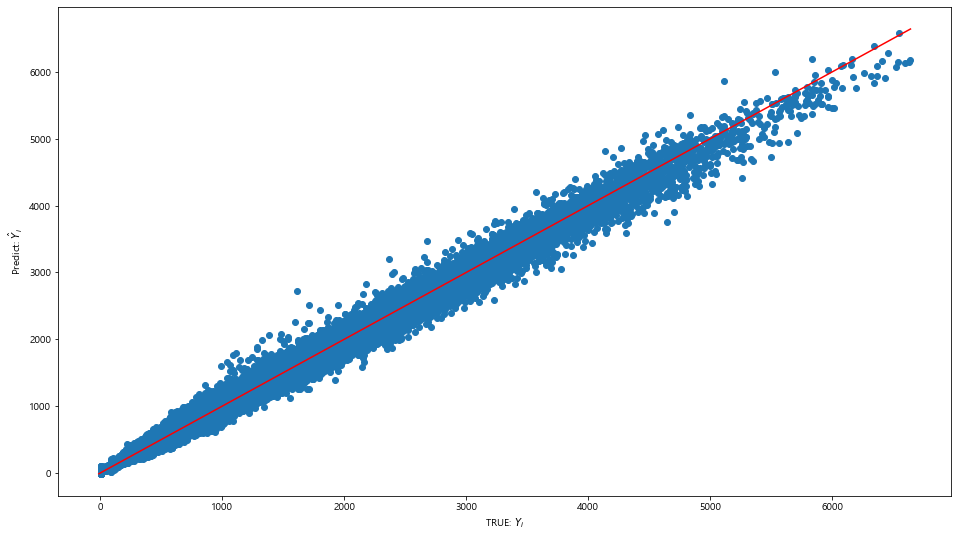

In [427]:
# for i in range(len(val_y)) :
y_pred_ = re.predict(X_val_ts)

x = val_yy.copy()
y = y_pred_.copy()

min_val = np.min([x.min(), y.min()])
max_val = np.max([x.max(), y.max()])


plt.scatter(x, y)
plt.xlabel("TRUE: $Y_i$")
plt.ylabel("Predict: $\hat{Y}_i$")

plt.plot([min_val, max_val], [min_val, max_val], color='r')

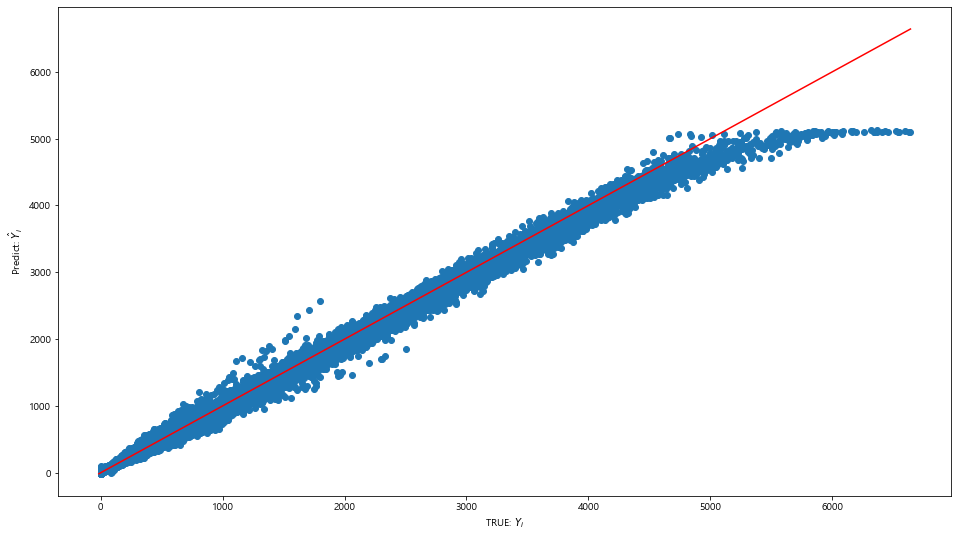

In [441]:
# for i in range(len(val_y)) :
y_pred_ = re.predict(X_val_ts)

x = val_yy.copy()
y = y_pred_.copy()

min_val = np.min([x.min(), y.min()])
max_val = np.max([x.max(), y.max()])


plt.scatter(x, y)
plt.xlabel("TRUE: $Y_i$")
plt.ylabel("Predict: $\hat{Y}_i$")

plt.plot([min_val, max_val], [min_val, max_val], color='r')

In [79]:
b = pd.Series(y_pred_2.reshape(-1))

In [84]:
c = b - y_train.values

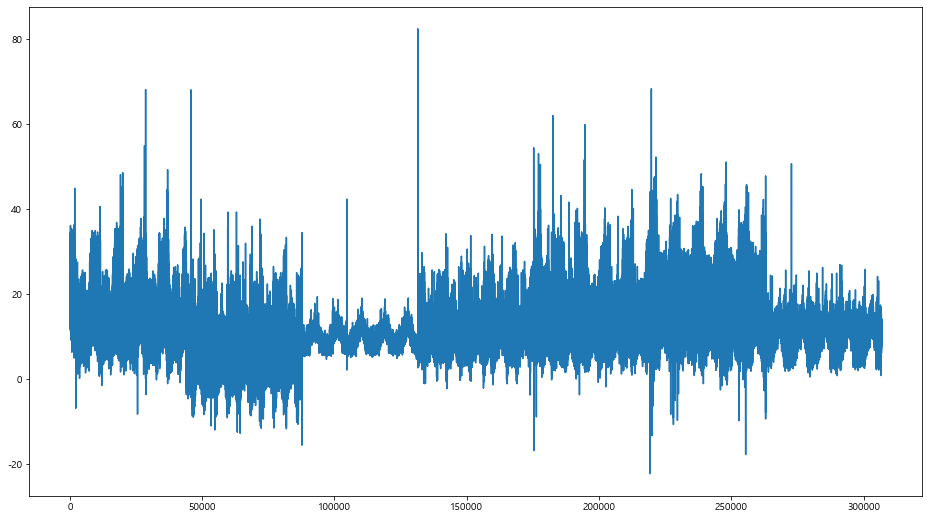

In [85]:
plt.plot(np.arange(b.shape[0]), c)

## Metric

In [428]:
# CNN
from sklearn.metrics import mean_squared_error, r2_score
y_pred_ = re.predict(X_val_ts)
mse = mean_squared_error(val_yy, y_pred_)
rmse = mse**0.5
r_2 = r2_score(val_yy, y_pred_)

print(mse)
print(rmse)
print(r_2)

7815.333756100331
88.4043763402035
0.9923494375655159


In [442]:
# LSTM
from sklearn.metrics import mean_squared_error, r2_score
y_pred_ = re.predict(X_val_ts)
mse = mean_squared_error(val_yy, y_pred_)
rmse = mse**0.5
r_2 = r2_score(val_yy, y_pred_)

print(mse)
print(rmse)
print(r_2)

5437.676344879389
73.74060173933617
0.9946769666308178


In [297]:
for i in range(len(LSTM_results)) :
    y_pred_ = results[i].predict(val_X[i])
    mse = mean_squared_error(val_y[i], y_pred_)
    rmse = mse**0.5
    r_2 = r2_score(val_y[i], y_pred_)

    print(mse)
    print(rmse)
    print(r_2)
    print('----------')

11905.277452323353
109.11130762814344
0.9802535338435687
----------
7976.7369856078485
89.31258022030183
0.9852852545662121
----------
57.754334541059016
7.599627263297787
0.9881797683487876
----------
3401.985171770585
58.32653917189486
0.9851648680121685
----------
19724.76911862882
140.44489709002895
0.9820144197420623
----------
56032.71190652652
236.71229775093335
0.9566843451006422
----------
506.6085011869559
22.507965283138233
0.9850421716720325
----------


## Inference 

### Test set preprocessing

In [81]:
# test => inference dataset
test = pd.read_csv('C:/Users/jhl/Downloads/test/test.csv')
submission = pd.read_csv('C:/Users/jhl/Downloads/test/sample_submission.csv')

In [82]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday

In [83]:
data['연월일'] = data['연월일'].astype('str')
data['시간'] = data['시간'].astype('str')

test['일자'] = test['일자'].astype('str')
test['시간'] = test['시간'].astype('str')

data['월일시'] = data['연월일'].str[5:] + '_' + data['시간']
test['월일시'] = test['일자'].str[5:] + '_' + test['시간']

In [84]:
# 5D_moving_avg 얘도 구분별로 이동평균 해야겠다

In [85]:
date = []
supplier = []
mv_avg = []
resid_avg = []
seasonal_avg = []
trend_avg = []

for i in tqdm(test['월일시'].unique()) :
#     df_mv_avg = final_df[final_df['월일시']==i]
    df_mv_avg = final_df[final_df['월일시']==i]
    
    for j in df_mv_avg['구분'].unique() :
        supplier_mean_df = df_mv_avg[df_mv_avg['구분']==j]
        mean_list = round(np.mean(supplier_mean_df['5D_moving_avg']),4)
#         resid_list = round(np.mean(supplier_mean_df['resid']),4)
#         seasonal_list = round(np.mean(supplier_mean_df['seasonal']),4)
#         trend_list = round(np.mean(supplier_mean_df['trend']),4)
     
        date.append(supplier_mean_df['월일시'].iloc[0])
        supplier.append(supplier_mean_df['구분'].iloc[0])
        mv_avg.append(mean_list)
#         resid_avg.append(resid_list)
#         seasonal_avg.append(seasonal_list)
#         trend_avg.append(trend_list)

100%|██████████████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.62it/s]


In [86]:
temp_df = pd.DataFrame()

In [87]:
temp_df['월일시'] = date
temp_df['구분'] = supplier
temp_df['5D_moving_avg'] = mv_avg
# temp_df['resid'] = resid_avg
# temp_df['seasonal'] = seasonal_avg
# temp_df['trend']  = trend_avg

In [88]:
test_set = pd.merge(test, temp_df, on = ['구분','월일시'], how = 'left')

In [89]:
dfs_ = pd.read_csv('C:/Users/jhl/Downloads/test/대전_평균기온_for2019.csv')
test_set['기온'] = dfs_['avg6']

In [90]:
test_dummies = pd.get_dummies(test_set, columns = ['구분'])

### Test set preprocessing2

In [95]:
features_test = ['시간', 'year', 'month', 'day', 'weekday', 
                 '5D_moving_avg', '기온',
                '구분_A', '구분_B', '구분_C','구분_D', '구분_E', '구분_G', '구분_H']

test_x = test_dummies[features_test]

test_x['시간'] = test_x['시간'].astype(int)

In [96]:
test_x_A = pd.DataFrame()
test_x_B = pd.DataFrame()
test_x_C = pd.DataFrame()
test_x_D = pd.DataFrame()
test_x_E = pd.DataFrame()
test_x_G = pd.DataFrame()
test_x_H = pd.DataFrame()
test_list = [test_x_A, test_x_B, test_x_C, test_x_D, test_x_E, test_x_G, test_x_H]
sup = ['구분_A', '구분_B', '구분_C','구분_D', '구분_E', '구분_G', '구분_H']

In [112]:
new_test_ = pd.DataFrame()
for i, name in zip(sup, test_list) : 
    test_x_ = test_x[test_x[i] == 1]
    val_24 = X_val[X_val[i] == 1][-24:]
    new_test = pd.concat([val_24, test_x_])
    new_test = new_test.reset_index(drop=True)
    new_test_ = new_test_.append(new_test)

In [106]:
test_x_A = new_test_[:2184]
test_x_B = new_test_[2184:2184*2]
test_x_C = new_test_[2184*2:2184*3]
test_x_D = new_test_[2184*3:2184*4]
test_x_E = new_test_[2184*4:2184*5]
test_x_G = new_test_[2184*5:2184*6]
test_x_H = new_test_[2184*6:2184*7]

temp_A = split_sequence_X(test_x_A, 24)
temp_B = split_sequence_X(test_x_B, 24)
temp_C = split_sequence_X(test_x_C, 24)
temp_D = split_sequence_X(test_x_D, 24)
temp_E = split_sequence_X(test_x_E, 24)
temp_G = split_sequence_X(test_x_G, 24)
temp_H = split_sequence_X(test_x_H, 24)

In [109]:
temp_list = [temp_A,temp_B,temp_C,temp_D,temp_E,temp_G,temp_H]

In [110]:
test_all = np.concatenate(temp_list)

In [111]:
test_all.shape

(15120, 24, 14)

In [120]:
for num, j in enumerate(temp_list) :
    train_scaled = scaler.fit(train_X[num].reshape(-1,1))
    temp_list[num] = train_scaled.fit_transform(temp_list[num].reshape(-1,1))
    temp_list[num] = temp_list[num].reshape(2160, 24, 14)

In [121]:
test_all = np.concatenate(temp_list)

In [122]:
# final_results = []
# for i in range(7) :
#     temp_predict = results[i].predict(temp_list[i])
#     final_results.append(temp_predict)

In [123]:
# final_results = []
# for i in range(7) :
#     temp_predict = LSTM_results[i].predict(temp_list[i])
#     final_results.append(temp_predict)

In [134]:
# submission['공급량'] = np.row_stack(final_results)
# submission['공급량'] = re.predict(test_all)
# test_set['공급량'] = submission['공급량']

In [125]:
# test_set.loc[test_set['구분']==cate, ['공급량']]

In [126]:
# import matplotlib.dates as mdates

# for cate in test_set['구분'].unique():
#     temp = test_set.loc[test_set['구분']==cate, ['일자','공급량']]
#     temp['일자'] = pd.to_datetime(temp['일자'])

#     plt.figure(figsize=(15,12))
#     plt.plot(temp['일자'], temp['공급량'])

#     plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30)) 
#     plt.xticks(rotation=90)
#     plt.title(cate)
#     plt.show()

In [128]:
# plt.plot(re.predict(test_all))

In [129]:
# submission.to_csv('C:/Users/jhl/Downloads/test/submission53.csv', index=False)

## Model save & load

In [155]:
# from tensorflow.python.keras.models import load_model
# model.save("C:/Users/jhl/Downloads/test/LSTM_checkpoint-trial-001.h5")
# model = load_model("C:/Users/jhl/Downloads/test/lstm_model_3.h5")
# a = model.predict(test_t, batch_size=1)

### 앙상블

In [130]:
import random
import tensorflow as tf
import tensorflow_addons as tfa

## chk available GPU and set memory growth
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
## set seed for random operations in order to reproduce results. All random state uses this value
seed=42
## set random seed to reproduce result
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## chk tf & tfa version
tf.__version__, tfa.__version__

('2.6.1', '0.15.0')

In [132]:
## func that returns optimizer. Lookahead + Rectified Adam is used.
def get_opt(init_lr=5e-4):
    RAdam = tfa.optimizers.RectifiedAdam(learning_rate=init_lr)
    opt = tfa.optimizers.Lookahead(RAdam)
    opt = tf.keras.optimizers.Adam(learning_rate=init_lr)
    opt = tf.keras.optimizers.SGD(learning_rate=init_lr)
    return opt

## func that is used as Pinball loss
from tensorflow.keras.backend import mean, maximum
def quantile_loss(q, y, f):
    err = (y-f)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [149]:
X_train_ts.shape, X_val_ts.shape, train_yy.shape, val_yy.shape

((306600, 24, 14), (61152, 24, 14), (306600,), (61152,))

In [150]:
import random
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [155]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
from lightgbm import LGBMRegressor


## LGBM model structure and hyper-params
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    model = LGBMRegressor(objective='quantile', alpha=q,
                          #boosting_type ='dart',
                          n_estimators=99999, 
                          num_leaves=18,
                          min_data_in_leaf = 35,
                          bagging_fraction=0.8, 
                          bagging_freq=10,
                          bagging_seed=1234,
                          feature_fraction=0.7,
                          feature_fraction_seed=seed,
                          learning_rate=1e-2,
                          random_seed=seed)

    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_train, Y_train),(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model





models_LGBM=[]
results_LGBM = []

## train model. prediction for day7 and day 8 are sperately handled by distinct model.

for q in quantiles:
    print(q)
    pred1 , model1 = LGBM(q, X_train, y_train, X_val, y_val, test_x)
#     print(q, 'day8')
#     pred2 , model2 = LGBM(q, flat_X_train, flat_Y_train2, flat_X_valid, flat_Y_valid2, flat_test)
    models_LGBM.append(model1)
#     models_LGBM.append(model2)
    results_LGBM.append(pred1)
#     results_LGBM.append(pred2)
    print('--------------------------학습 종료---------------------')

np.asarray(results_LGBM).shape

0.1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[500]	training's quantile: 35.7921	valid_1's quantile: 42.0748
[1000]	training's quantile: 16.7359	valid_1's quantile: 20.5179
[1500]	training's quantile: 11.1918	valid_1's quantile: 13.5409
[2000]	training's quantile: 9.05421	valid_1's quantile: 10.6612


KeyboardInterrupt: 

In [156]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
## train random forest for day7 prediction
N_ESTIMATORS = 1000
rf =  RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=0.7,
                                    max_samples=0.8,
                                    min_samples_split=20,
                                    random_state=seed,
                                    n_jobs=-1)
rf.fit(X_train, y_train)
print(mean_absolute_error(rf.predict(X_train), y_train))

KeyboardInterrupt: 

In [303]:
rf_preds = []
for estimator in rf.estimators_:
    rf_preds.append(estimator.predict(test_x))
rf_preds = np.array(rf_preds)

# random forest quantile regression using quantile distribution of base trees in random forest ensemble.
for i, q in enumerate(quantiles):
    y_pred = np.percentile(rf_preds, q * 100, axis=0)
#     y_pred2 = np.percentile(rf_preds2, q * 100, axis=0)
#     rf_submission.loc[rf_submission.id.str.contains("_RF"),"q_0."+str(int(i+1))] = np.ravel(y_pred)
#     rf_submission.loc[rf_submission.id.str.contains("_Day8"),"q_0."+str(int(i+1))] = np.ravel(y_pred2)

In [168]:
X_train_ts.shape

(306600, 24, 14)

In [161]:
## train and predict Test data
## models for each 4 ML methods and 9 quantiles are trained
def TF_train_func(X_train, Y_train, X_valid, Y_valid, X_test):
    models=[]
    actual_pred = []
    
    for model_select in ['CNN','FFN','LSTM','CNNLSTM'
                 ]:
        score_lst=[]
        for q in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
            print(model_select, q)
            if model_select=='LSTM':
                pred , mod, s = LSTM(q, X_train, Y_train, X_valid, Y_valid, X_test)
            elif model_select=='CNN':
                pred , mod, s = CNN(q, X_train, Y_train, X_valid, Y_valid, X_test)
            elif model_select=='CNNLSTM':
                pred , mod, s = CNN_LSTM(q, X_train, Y_train, X_valid, Y_valid, X_test)
            elif model_select=='FFN':
                pred , mod, s = FFN(q, X_train, Y_train, X_valid, Y_valid, X_test)
            score_lst.append(s)
            models.append(mod)
            actual_pred.append(pred)
        print(sum(score_lst)/len(score_lst))
    return models, np.asarray(actual_pred)

In [162]:
## CNN model structure
def CNN(q, X_train, Y_train, X_valid, Y_valid, X_test):
    inputs = tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2]), name='input')
    
    norm = tf.keras.layers.experimental.preprocessing.Normalization()
    norm.adapt(X_train)
    norm_data = norm(inputs)
    x = tf.keras.layers.Conv1D(50, 3, activation='relu', 
                               kernel_initializer='he_normal')(norm_data)
    x = tf.keras.layers.Conv1D(30, 3, activation='relu', 
                               kernel_initializer='he_normal')(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    x= tf.keras.layers.Dense(Y_train.shape[-1])(x)
    x1= tf.keras.layers.Flatten()(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=x1)
    tf.keras.utils.plot_model(model, show_shapes=True)
#     model.summary()
    model.compile(loss=lambda y,f: quantile_loss(q,y,f), optimizer=get_opt())
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
    history = model.fit(X_train, Y_train, epochs=500, batch_size=16,
                        shuffle=True, validation_data=[X_valid, Y_valid], 
                        callbacks=[es], verbose=0)
    

    train_score = np.asarray(quantile_loss(q,Y_train,model.predict(X_train))).flatten().mean()
    val_score = np.asarray(quantile_loss(q,Y_valid,model.predict(X_valid))).flatten().mean()
    print(train_score, val_score)
    pred = np.asarray(model.predict(X_test))
    return pred, model, val_score

In [163]:
## Feed Forward Network (Multilayer Perceptron) structure
def FFN(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    inputs = tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2]), name='input')
    norm = tf.keras.layers.experimental.preprocessing.Normalization()
    norm.adapt(X_train)
    norm_data = norm(inputs)
    
    x = tf.keras.layers.Flatten()(norm_data)
    x = tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
    x = tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
    
    x1= tf.keras.layers.Dense(Y_train.shape[-1])(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=x1)
    tf.keras.utils.plot_model(model, show_shapes=True)
    
    model.compile(loss=lambda y,f: quantile_loss(q,y,f), optimizer=get_opt())
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
    history = model.fit(X_train, Y_train, epochs=500, batch_size=16,
                        shuffle=True, validation_data=[X_valid, Y_valid], 
                        callbacks=[es], verbose=0)
    

    train_score = np.asarray(quantile_loss(q,Y_train,model.predict(X_train))).flatten().mean()
    val_score = np.asarray(quantile_loss(q,Y_valid,model.predict(X_valid))).flatten().mean()
    print('overall score: ',train_score, val_score)
    pred = np.asarray(model.predict(X_test))
    return pred, model, val_score

In [164]:
## LSTM model structure
def LSTM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    inputs = tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2]), name='input')
    
    norm = tf.keras.layers.experimental.preprocessing.Normalization()
    norm.adapt(X_train)
    norm_data = norm(inputs)
    x =tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_initializer='he_normal', recurrent_dropout=0.3, return_sequences=True))(norm_data)
    x= tf.keras.layers.Dense(1)(x)
    x1= tf.keras.layers.Flatten()(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=x1)
    tf.keras.utils.plot_model(model, show_shapes=True)
    
    model.compile(loss=lambda y,f: quantile_loss(q,y,f), optimizer=get_opt(1e-2))
#     model.summary()
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
    history = model.fit(X_train, Y_train, epochs=500, batch_size=16,
                        shuffle=True, validation_data=[X_valid, Y_valid], 
                        callbacks=[es], verbose=0)
    

    train_score = np.asarray(quantile_loss(q,Y_train,model.predict(X_train))).flatten().mean()
    val_score = np.asarray(quantile_loss(q,Y_valid,model.predict(X_valid))).flatten().mean()
    print(train_score, val_score)
    pred = np.asarray(model.predict(X_test))
    return pred, model, val_score

In [160]:
## train and predict Test data
## models for each 4 ML methods and 9 quantiles are trained
def TF_train_func(X_train, Y_train, X_valid, Y_valid, X_test):
    models=[]
    actual_pred = []
    
    for model_select in ['CNN','FFN','LSTM','CNNLSTM'
                 ]:
        score_lst=[]
        for q in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
            print(model_select, q)
            if model_select=='LSTM':
                pred , mod, s = LSTM(q, X_train, Y_train, X_valid, Y_valid, X_test)
            elif model_select=='CNN':
                pred , mod, s = CNN(q, X_train, Y_train, X_valid, Y_valid, X_test)
            elif model_select=='CNNLSTM':
                pred , mod, s = CNN_LSTM(q, X_train, Y_train, X_valid, Y_valid, X_test)
            elif model_select=='FFN':
                pred , mod, s = FFN(q, X_train, Y_train, X_valid, Y_valid, X_test)
            score_lst.append(s)
            models.append(mod)
            actual_pred.append(pred)
        print(sum(score_lst)/len(score_lst))
    return models, np.asarray(actual_pred)

In [178]:
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot

In [179]:
models_tf, results_tf  = TF_train_func(X_train_ts, train_yy, X_val_ts, val_yy, test_all)

CNN 0.1


ResourceExhaustedError: OOM when allocating tensor with shape[600,306600] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [146]:
## make prediction on validation dataset for all models. 
## 4*9*2 tensorflow models
## 9*2 LGBM models
## 2 RandomForest models

## LGBM valid predictions
print(len(models_LGBM))
lgbm_lst=[]
for i in tqdm(range(9)):
    pred1=models_LGBM[i].predict(X_val)
    lgbm_lst.append(pred1)
print(np.asarray(lgbm_lst).shape)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

9


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:29<00:00, 29.97s/it]

(9, 61320)


In [150]:
## Random Forest valid predictions    
rf_preds = []
for estimator in rf.estimators_:
    rf_preds.append(estimator.predict(X_val))
rf_preds = np.array(rf_preds)

In [155]:
rf_lst=[]
for i, q in enumerate(quantiles):
    y_pred = np.percentile(rf_preds, q * 100, axis=0)
#     y_pred2 = np.percentile(rf_preds2, q * 100, axis=0)
    rf_lst.append(y_pred)
print(np.asarray(rf_lst).shape)

(9, 61320)


In [ ]:
tf_lst=[]
for i in range(4):
    tmp=[]
    for j in range(9):
        model1=models_tf[i*9+j]
        pred1=model1.predict(X_val_ts)
        d1_q=pred1.flatten()
        tmp.append([d1_q.flatten()])
    tf_lst.append(tmp)
print(np.asarray(tf_lst).shape)

print(np.append([lgbm_lst,rf_lst],np.asarray(tf_lst), axis=0).shape)
print(X_val_ts.shape)

In [147]:
## concat all validation data predictions for linear ensemble 
# ensemble_data=np.append([lgbm_lst,rf_lst],np.asarray(tf_lst), axis=0)
# ensemble_data=np.moveaxis(ensemble_data.reshape(ensemble_data.shape[0]*ensemble_data.shape[1],2,-1),0,-1)
# ensemble_data=np.moveaxis(ensemble_data,0,1)
# print(ensemble_data.shape)


## linear regression is used for meta model.
## instead of using 6 models for ensemble, other models trained to predict different quantiles are also used 
## (6 ML techniques * 9 quantiles = 54 models in total)
## each of 54 models are expected to extract similar but different features from input data therefore ensembling will improve accuracy
def linear_quantile(q, x, y):
    
    inputs = tf.keras.layers.Input(shape=(6*9,))
    norm = tf.keras.layers.experimental.preprocessing.Normalization()
    norm.adapt(x)
    norm_data = norm(inputs)
    preds = tf.keras.layers.Dense(1)(norm_data)
    model = tf.keras.models.Model(inputs=inputs,outputs=preds)
    
    model.summary()
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                  loss=lambda y,f: quantile_loss(q,y,f))
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001, verbose=1)
    model.fit(x,y, validation_split=0.3, batch_size=1, epochs=50, shuffle=True, verbose=True, callbacks=[es])
    print(model.layers[-1].get_weights())
    return model

## ensembling is done for each 9 quantiles and 2 target days
## 9 quantiles * 2 TARGET days = 18 meta models in total
linear_models=[]
for q in quantiles:
    print(q)
    a=linear_quantile(q,ensemble_data[:,0,:],flat_Y_valid1)
    b=linear_quantile(q,ensemble_data[:,1,:],flat_Y_valid2)
    linear_models.append([a,b])
linear_models=np.asarray(linear_models)
linear_models.shape

In [ ]:
## base models predictions for test data are made
def submission_fill(pred1, pred2):
    df = pd.read_csv('./data/sample_submission.csv')
    
    df.loc[df.id.str.contains("_Day7"),"q_0.1":] = pred1
    df.loc[df.id.str.contains("_Day8"),"q_0.1":] = pred2
    df.drop('id',axis=1,inplace=True)
    return df


lst1=[]
lst2=[]
for i in range(9):
    model1=models_LGBM[i*2]
    model2=models_LGBM[i*2+1]
    lst1.append(model1.predict(flat_test))
    lst2.append(model2.predict(flat_test))
LGBM_result = submission_fill(np.asarray(lst1).transpose(),np.asarray(lst2).transpose())


tf_pred_lst1=[]
tf_pred_lst2=[]
for i in range(4):
    lst1=[]
    lst2=[]
    for j in range(9):
        model1=models_tf1[j+9*i]
        model2=models_tf2[j+9*i]
        tf_pred_lst1.append(model1.predict(tf_test))
        tf_pred_lst2.append(model2.predict(tf_test))
l1=np.moveaxis(np.asarray(tf_pred_lst1),0,-1).reshape((-1,36))
l2=np.moveaxis(np.asarray(tf_pred_lst2),0,-1).reshape((-1,36))
print(l1.shape, l2.shape)

CNN_result = submission_fill(l1[:,0:9],l2[:,0:9])
FFN_result = submission_fill(l1[:,9:18],l2[:,9:18])
LSTM_result = submission_fill(l1[:,18:27],l2[:,18:27])
CNNLSTM_result = submission_fill(l1[:,27:36],l2[:,27:36])
df_concat = pd.concat((LGBM_result, rf_submission, CNN_result, FFN_result, LSTM_result, CNNLSTM_result),axis=1)
print(df_concat.shape)



## final ensemble prediction for test data is made using base model predictions.
## prediction results are rounded up to second decimal for simplicity.
ensem_sub = pd.read_csv('./data/sample_submission.csv')
day7_d=df_concat.loc[df_concat.id.str.contains("_Day7"), :].drop('id',axis=1).values
day8_d=df_concat.loc[df_concat.id.str.contains("_Day8"), :].drop('id',axis=1).values
for q in quantiles:
    idx=int(q*10-1)
    model1=linear_models[idx][0]
    model2=linear_models[idx][1]
    ensem_1=model1.predict(day7_d)
    ensem_2=model2.predict(day8_d)
    ensem_sub.loc[ensem_sub.id.str.contains("_Day7"),'q_'+str(q)] = ensem_1
    ensem_sub.loc[ensem_sub.id.str.contains("_Day8"),'q_'+str(q)] = ensem_2
        
ensem_sub.loc[:,'q_0.1':] = ensem_sub.loc[:,'q_0.1':].round(2)
ensem_sub

In [174]:
cnn_lst = np.asarray(np.column_stack(y_pred_))

In [178]:
a = np.append(lgbm_lst,rf_lst, axis=0)

In [182]:
a.shape

(18, 61320)

In [183]:
cnn_lst.shape

(1, 61320)

In [180]:
final_lst = np.append(a,cnn_lst, axis=0)

In [213]:
## tensorflow models(4) valid predictions
# tf_lst=[]
# for i in range(4):
#     tmp=[]
#     for j in range(9):
#         model1=models_tf1[i*9+j]
#         model2=models_tf2[i*9+j]
#         pred1=model1.predict(TF_X_valid)
#         pred2=model2.predict(TF_X_valid)
#         d1_q=pred1.flatten()
#         d2_q=pred2.flatten()
#         tmp.append([d1_q.flatten(), d2_q.flatten()])
#     tf_lst.append(tmp)
# print(np.asarray(y_pred_).shape)
cnn_lst = np.asarray(np.column_stack(y_pred_))
a = np.append(lgbm_lst,rf_lst, axis=0)
final_lst = np.append(a,cnn_lst, axis=0)
print(final_lst.shape)
# print(flat_Y_valid1.shape)
# print(flat_Y_valid2.shape)

(19, 61320)


In [222]:
X_train_t.shape

(306768, 14, 1)

In [198]:
ensemble_data.

(19, 61320)

In [470]:
ensemble_data= final_lst.copy()
ensemble_data= ensemble_data.reshape(ensemble_data.shape[1],ensemble_data.shape[0],1)

In [489]:
## concat all validation data predictions for linear ensemble 
ensemble_data= final_lst.copy()
# ensemble_data= ensemble_data.reshape(ensemble_data.shape[1],ensemble_data.shape[0],1)
ensemble_data= ensemble_data.reshape(ensemble_data.shape[1],ensemble_data.shape[0],1)
# ensemble_data=np.moveaxis(ensemble_data,0,1)
print(ensemble_data.shape)


## linear regression is used for meta model.
## instead of using 6 models for ensemble, other models trained to predict different quantiles are also used 
## (6 ML techniques * 9 quantiles = 54 models in total)
## each of 54 models are expected to extract similar but different features from input data therefore ensembling will improve accuracy
def linear_quantile(q, x, y):
    
    inputs = tf.keras.layers.Input(shape=(ensemble_data.shape[1],))
    norm = tf.keras.layers.experimental.preprocessing.Normalization()
    norm.adapt(x)
    norm_data = norm(inputs)
    preds = tf.keras.layers.Dense(1)(norm_data)
    model = tf.keras.models.Model(inputs=inputs,outputs=preds)
    
    model.summary()
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                  loss=lambda y,f: quantile_loss(q,y,f))
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001, verbose=1)
    
    model.fit(x,y, validation_split=0.3, batch_size=1, epochs=10, shuffle=True, verbose=True, callbacks=[es])
    print(model.layers[-1].get_weights())
#     print(model.sumarry())
    return model

(61320, 19, 1)


In [476]:
len(ensemble_data[:,0,:])

61320

In [477]:
# 0.1 이하의 값이 들어가는 모델이 되는지??
quantiles = [0.1,0.2,0.3,0.4]

In [479]:
#  last gas

In [540]:
ensemble_data[:,:].shape

(61320, 19, 1)

In [491]:
## ensembling is done for each 9 quantiles and 2 target days
## 9 quantiles * 2 TARGET days = 18 meta models in total
# 1 epoch 7분
linear_models=[]
for q in quantiles:
    print(q)
    a=linear_quantile(q,ensemble_data[:,:],y_val)
#     b=linear_quantile(q,ensemble_data[:,1,:],flat_Y_valid2)
    linear_models.append(a)
linear_models=np.asarray(linear_models)
linear_models.shape

0.1
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 19)]              0         
_________________________________________________________________
normalization_14 (Normalizat (1, None, 19)             3         
_________________________________________________________________
dense_14 (Dense)             (1, None, 1)              20        
Total params: 23
Trainable params: 20
Non-trainable params: 3
_________________________________________________________________
Epoch 1/10
42924/42924 [==============================] - 456s 11ms/step - loss: 85.6779 - val_loss: 131.1576
Epoch 2/10
42924/42924 [==============================] - 443s 10ms/step - loss: 83.5827 - val_loss: 129.3382
Epoch 3/10
42924/42924 [==============================] - 448s 10ms/step - loss: 81.8545 - val_loss: 128.1446
Epoch 4/10
42924/42924 [==============================] - 

(4,)

In [ ]:
# window sliding 해보기

In [ ]:
# test로 예측한 값 -> concat 하고 -> linear 모델에 넣어서 예측
y_pred_cnn, rf_preds, results_LGBM

In [293]:
results_LGBM[0]

0        1737.31
1        1564.52
2        1502.96
3        1592.11
4        1786.40
          ...   
15115     303.21
15116     304.00
15117     291.38
15118     260.30
15119     243.10
Length: 15120, dtype: float64

In [423]:
rf_meadn_preds = pd.DataFrame()
for i in range(9,1000,111) :
    temp_mean = pd.DataFrame(rf_preds[i-9 :i-1]).T.mean(axis=1)
    print(temp_mean)
    rf_meadn_preds = rf_meadn_preds.append(temp_mean,ignore_index=True)
rf_meadn_preds.T

0        1786.432346
1        1593.473194
2        1536.674927
3        1635.662763
4        1856.188051
            ...     
15115     321.325053
15116     326.905067
15117     296.846791
15118     286.906353
15119     269.745768
Length: 15120, dtype: float64
0        1802.708168
1        1614.515835
2        1542.467299
3        1645.208993
4        1874.217749
            ...     
15115     314.039641
15116     340.680162
15117     306.995475
15118     277.752573
15119     270.239639
Length: 15120, dtype: float64
0        1808.262527
1        1673.764761
2        1541.406661
3        1650.368055
4        1849.239430
            ...     
15115     312.434557
15116     316.831382
15117     302.910235
15118     282.431368
15119     261.368657
Length: 15120, dtype: float64
0        1789.672794
1        1678.188832
2        1559.814240
3        1650.451554
4        1867.801220
            ...     
15115     318.230276
15116     329.692052
15117     308.057090
15118     284.349806
15119  

,0,1,2,3,4,5,6,7,8
0,1786.432346,1802.708168,1808.262527,1789.672794,1851.623213,1821.180627,1792.831784,1823.598864,1815.898845
1,1593.473194,1614.515835,1673.764761,1678.188832,1594.640339,1630.680246,1621.906690,1721.618700,1618.138318
2,1536.674927,1542.467299,1541.406661,1559.814240,1529.600704,1568.472845,1561.271038,1521.485782,1545.030078
3,1635.662763,1645.208993,1650.368055,1650.451554,1647.824855,1642.588180,1657.621588,1643.304910,1637.841604
4,1856.188051,1874.217749,1849.239430,1867.801220,1877.192367,1862.301367,1896.085870,1858.808917,1862.048139
...,...,...,...,...,...,...,...,...,...
15115,321.325053,314.039641,312.434557,318.230276,312.061743,300.250405,306.840512,304.556857,313.388335
15116,326.905067,340.680162,316.831382,329.692052,316.722043,331.687196,335.744001,308.256099,327.415390
15117,296.846791,306.995475,302.910235,308.057090,298.917164,300.309018,297.747459,289.702942,317.759866
15118,286.906353,277.752573,282.431368,284.349806,293.683038,281.712059,282.403757,283.499436,279.413298


In [425]:
rf_pred = np.array(rf_meadn_preds)

In [426]:
test_cnn_lst = np.asarray(np.column_stack(y_pred_cnn))
test_a = np.append(results_LGBM,rf_pred, axis=0)
final_test_lst = np.append(test_a,test_cnn_lst, axis=0)

In [427]:
all_df = pd.DataFrame(final_test_lst)

In [428]:
all_average_df = all_df.mean()

In [429]:
all_average_df

0        1813.151191
1        1644.633216
2        1557.677620
3        1644.193822
4        1849.846160
            ...     
15115     315.543079
15116     321.909751
15117     298.872427
15118     276.576096
15119     258.600106
Length: 15120, dtype: float64

In [493]:
ensemble_test_data= final_test_lst.copy()
# ensemble_data= ensemble_data.reshape(ensemble_data.shape[1],ensemble_data.shape[0],1)
ensemble_test_data = ensemble_test_data.reshape(ensemble_test_data.shape[1],ensemble_test_data.shape[0],1)

In [316]:
## base models predictions for test data are made
# def submission_fill(pred1, pred2):
#     df = pd.read_csv('./data/sample_submission.csv')
    
#     df.loc[df.id.str.contains("_Day7"),"q_0.1":] = pred1
# #     df.loc[df.id.str.contains("_Day8"),"q_0.1":] = pred2
#     df.drop('id',axis=1,inplace=True)
#     return df

submission_fill = pd.DataFrame()
lst1=[]
lst2=[]
for i in range(9):
    model1=models_LGBM[i]
#     model2=models_LGBM[i*2+1]
    lst1.append(model1.predict(test_x))
#     lst2.append(model2.predict(flat_test))
LGBM_result = submission_fill(np.asarray(lst1).transpose())

TypeError: 'DataFrame' object is not callable

In [324]:
submission['공급량'] = np.asarray(lst1).transpose()

In [340]:
submission['공급량'] = all_average_df

In [342]:
submission.to_csv('C:/Users/jhl/Downloads/test/submission43.csv', index=False)

In [ ]:
CNN_result = submission_fill(l1[:,0:9],l2[:,0:9])
FFN_result = submission_fill(l1[:,9:18],l2[:,9:18])
LSTM_result = submission_fill(l1[:,18:27],l2[:,18:27])
CNNLSTM_result = submission_fill(l1[:,27:36],l2[:,27:36])
df_concat = pd.concat((LGBM_result, rf_submission, CNN_result, FFN_result, LSTM_result, CNNLSTM_result),axis=1)
print(df_concat.shape)

In [ ]:
test_cnn_lst = np.asarray(np.column_stack(y_pred_cnn))
test_a = np.append(results_LGBM,rf_pred, axis=0)
final_test_lst = np.append(test_a,test_cnn_lst, axis=0)

In [556]:
pd.DataFrame(test_a).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1737.31,1778.17,1779.03,1804.58,1832.68,1840.59,1861.58,1881.30,1925.01,1786.432346,1802.708168,1808.262527,1789.672794,1851.623213,1821.180627,1792.831784,1823.598864,1815.898845
1,1564.52,1599.57,1610.62,1629.52,1655.43,1659.36,1688.78,1708.67,1774.97,1593.473194,1614.515835,1673.764761,1678.188832,1594.640339,1630.680246,1621.906690,1721.618700,1618.138318
2,1502.96,1529.75,1533.43,1539.96,1566.01,1571.51,1594.05,1602.71,1663.29,1536.674927,1542.467299,1541.406661,1559.814240,1529.600704,1568.472845,1561.271038,1521.485782,1545.030078
3,1592.11,1624.47,1630.71,1633.74,1626.64,1634.24,1638.31,1644.94,1704.53,1635.662763,1645.208993,1650.368055,1650.451554,1647.824855,1642.588180,1657.621588,1643.304910,1637.841604
4,1786.40,1799.49,1800.22,1788.24,1808.48,1850.60,1851.25,1924.11,1905.76,1856.188051,1874.217749,1849.239430,1867.801220,1877.192367,1862.301367,1896.085870,1858.808917,1862.048139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,303.21,310.49,314.73,314.94,321.18,325.99,321.04,327.92,334.83,321.325053,314.039641,312.434557,318.230276,312.061743,300.250405,306.840512,304.556857,313.388335
15116,304.00,309.12,324.48,320.49,321.53,324.47,320.07,329.43,335.93,326.905067,340.680162,316.831382,329.692052,316.722043,331.687196,335.744001,308.256099,327.415390
15117,291.38,296.38,298.13,296.12,298.39,295.35,298.33,305.76,306.19,296.846791,306.995475,302.910235,308.057090,298.917164,300.309018,297.747459,289.702942,317.759866
15118,260.30,266.51,269.75,265.92,267.51,272.50,274.30,280.11,287.85,286.906353,277.752573,282.431368,284.349806,293.683038,281.712059,282.403757,283.499436,279.413298


In [552]:
df_concat = pd.concat((test_cnn_lst, test_a),axis=1)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [549]:
aa = final_test_lst.reshape(final_test_lst.shape[1],final_test_lst.shape[0],1)

In [563]:
final_test_lst.expand_dims(1)

AttributeError: 'numpy.ndarray' object has no attribute 'expand_dims'

In [546]:
aa.shape

(15120, 19, 1)

In [547]:
aa = pd.DataFrame(final_test_lst.T)

In [551]:
len(linear_models)

4

In [550]:
## final ensemble prediction for test data is made using base model predictions.
## prediction results are rounded up to second decimal for simplicity.
# ensem_sub = pd.read_csv('./data/sample_submission.csv')
ensem = []
# day7_d=df_concat.loc[df_concat.id.str.contains("_Day7"), :].drop('id',axis=1).values
# day8_d=df_concat.loc[df_concat.id.str.contains("_Day8"), :].drop('id',axis=1).values
for q in range(len(quantiles)):
#     idx=int(q*10-1)
    model1=linear_models[q]
#     model2=linear_models[idx][1]
    ensem_1=model1.predict(aa)
    ensem.append(ensem_1)
#     ensem_2=model2.predict(day8_d)
#     ensem_sub.loc[ensem_sub.id.str.contains("_Day7"),'q_'+str(q)] = ensem_1
#     ensem_sub.loc[ensem_sub.id.str.contains("_Day8"),'q_'+str(q)] = ensem_2
# ensem_sub.loc[:,'q_0.1':] = ensem_sub.loc[:,'q_0.1':].round(2)
# ensem_sub

InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [1,32,1] vs. shape[472] = [1,16,1] [Op:ConcatV2] name: concat

In [539]:
np.array(ensem).shape

(0,)

In [451]:
np.array(ensem).reshape(4,15120).T

array([[102.09267 , 241.51103 , 299.3822  , 336.25763 ],
       [103.70058 , 239.11432 , 294.1126  , 329.0755  ],
       [102.24201 , 238.6595  , 291.76553 , 326.81815 ],
       ...,
       [100.03029 , 256.5451  , 336.6678  , 382.41556 ],
       [ 99.76734 , 256.58157 , 337.1239  , 383.39688 ],
       [100.045135, 256.29807 , 336.1644  , 381.9533  ]], dtype=float32)